# [Hands-On] Sound Classification using ViT

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

# Introduction

In this notebook, we explore how to use a Vision Transformer (ViT) model for sound classification. Vision Transformers, originally designed for image classification tasks, can be adapted to classify sounds by converting audio data into visual representations such as spectrograms.

We will:
1. Convert sound data into Mel-spectrograms.
2. Adapt the ViT model to handle these spectrograms by converting the single-channel (grayscale) images into three-channel images.
3. Train the model using a subset of the UrbanSound8K dataset.
4. Evaluate the model's performance and visualize the results with a confusion matrix.

By the end of this notebook, you'll see how powerful visual models like ViT can be in the realm of sound classification.

## 1. Setting Up the Colab Environment
First, install the required libraries and check if a GPU is available.

In [ ]:
!pip install -q librosa==0.10.2 seaborn
!pip install -q transformers==4.48.3 datasets


# Check if GPU is available
import torch
print("GPU available:", torch.cuda.is_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
GPU available: True


In [ ]:
import torch
import random
import os

# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

## 2. Load the UrbanSound8K Dataset
The UrbanSound8K dataset can be easily loaded using the Hugging Face Datasets library.

In [ ]:
from datasets import load_dataset

# Load the UrbanSound8K dataset
dataset = load_dataset("danavery/urbansound8K") # <-- it takes time about 10min.

# Check the dataset structure
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.66k [00:00<?, ?B/s]

(…)-00000-of-00016-e478d7cccca6a095.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

(…)-00001-of-00016-299138aa39afaa06.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

(…)-00002-of-00016-887e0748205b6fa9.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

(…)-00003-of-00016-691ee48aa53d9c1f.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

(…)-00004-of-00016-c0f37514d8e28a72.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00005-of-00016-55ef1a0a51149c01.parquet:   0%|          | 0.00/591M [00:00<?, ?B/s]

(…)-00006-of-00016-0ef363072505e6d5.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

(…)-00007-of-00016-dfac173beb21e5db.parquet:   0%|          | 0.00/588M [00:00<?, ?B/s]

(…)-00008-of-00016-2744487f32f65d77.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

(…)-00009-of-00016-83fc7364d4798177.parquet:   0%|          | 0.00/549M [00:00<?, ?B/s]

(…)-00010-of-00016-4c1d0e285ed77843.parquet:   0%|          | 0.00/353M [00:00<?, ?B/s]

(…)-00011-of-00016-79d186503a26671b.parquet:   0%|          | 0.00/316M [00:00<?, ?B/s]

(…)-00012-of-00016-6aff88fdcca22918.parquet:   0%|          | 0.00/372M [00:00<?, ?B/s]

(…)-00013-of-00016-17d827b1a5be0423.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

(…)-00014-of-00016-c630762df85f6cf4.parquet:   0%|          | 0.00/381M [00:00<?, ?B/s]

(…)-00015-of-00016-03506887d89adfc9.parquet:   0%|          | 0.00/335M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class'],
        num_rows: 8732
    })
})


## 3. Split the Dataset into Train and Validation Sets
Split the dataset into training and validation sets. We'll use an 80-20 split for training and validation.

In [ ]:
USE_FULL_DATA = True

if USE_FULL_DATA:
    train_test_split = dataset['train'].train_test_split(test_size=0.2, seed=42)
else:
    # Set the fraction of the dataset to use (e.g., 10%)
    fraction = 0.1

    # Sample a smaller subset of the dataset
    small_dataset = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * fraction)))

    # Split the smaller dataset into train (80%) and validation (20%) sets
    train_test_split = small_dataset.train_test_split(test_size=0.2, seed=42)  # <-- small dataset

train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']

## 4. Data Preprocessing
Preprocess the audio data to generate Mel Spectrograms, resize them, and prepare them as input images for the model.

In [ ]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, Resample
from torchvision.transforms import Resize, Normalize

# Define Mel Spectrogram transformation with adjusted n_mels
sample_rate = 22050
n_mels = 64  # Adjusted from 128 to 64 to avoid the warning
mel_spectrogram = MelSpectrogram(
    sample_rate=sample_rate,
    n_mels=n_mels
)

# Define resizing and normalization transformations
resize = Resize((224, 224))
normalize = Normalize(mean=[0.5], std=[0.5])

# Define a preprocessing function with data type consistency
def preprocess(example):
    audio = example['audio']['array']
    # Convert audio to a FloatTensor to match kernel dtype
    audio = torch.tensor(audio, dtype=torch.float32)
    # Resample if needed
    if example['audio']['sampling_rate'] != sample_rate:
        resample = Resample(orig_freq=example['audio']['sampling_rate'], new_freq=sample_rate)
        audio = resample(audio)

    # Generate Mel Spectrogram
    mel_spec = mel_spectrogram(audio)
    mel_spec = mel_spec.unsqueeze(0)  # (1, n_mels, time)

    # Convert to image and normalize
    mel_spec = resize(mel_spec)
    mel_spec = normalize(mel_spec)

    # Convert label to tensor
    label = torch.tensor(example['classID'], dtype=torch.long)

    return {'image': mel_spec, 'label': label}

# Apply preprocessing to train and validation datasets
train_dataset = train_dataset.map(preprocess, remove_columns=['audio', 'slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'class'], batched=False)
valid_dataset = valid_dataset.map(preprocess, remove_columns=['audio', 'slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'class'], batched=False)


Map:   0%|          | 0/6985 [00:00<?, ? examples/s]

Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

In [ ]:
# Extract unique class IDs from the train dataset to determine the number of classes
num_labels = len(set(train_dataset['label']))

print(f"Number of classes: {num_labels}")

Number of classes: 10


## 5. Visualize a Sample Mel Spectrogram
After preprocessing, select a sample from the training dataset and visualize the Mel Spectrogram.

In [ ]:
from IPython.display import Audio, display

sample = dataset['train'][0]
# Extract the audio array and sampling rate
audio_array = sample['audio']['array']
sampling_rate = sample['audio']['sampling_rate']

# Extract the audio array and sampling rate
audio_array = sample['audio']['array']
sampling_rate = sample['audio']['sampling_rate']

# Display audio player
print("Audio Player:")
display(Audio(audio_array, rate=sampling_rate))


Audio Player:


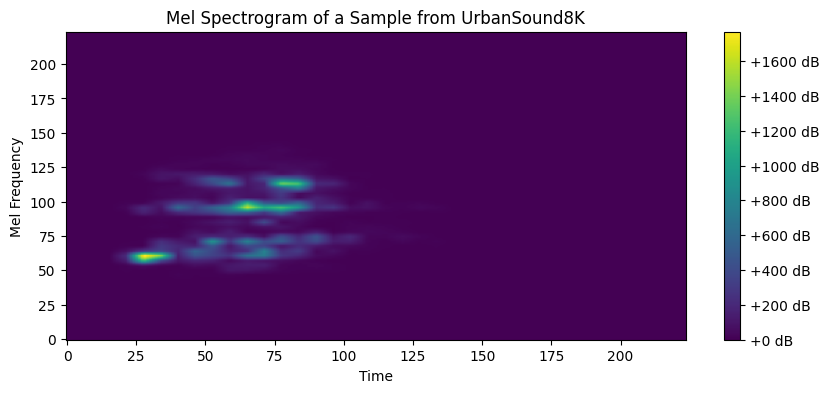

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select a sample from the training dataset
sample = preprocess(sample)

# Access the tensor
mel_spec = sample['image'][0]

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec, aspect='auto', origin='lower')
plt.title('Mel Spectrogram of a Sample from UrbanSound8K')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()



## 6. Prepare DataLoader
Prepare the dataset for training and evaluation using PyTorch's DataLoader.

In [ ]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## 7. Define the Vision Transformer (ViT) Model
Define the Vision Transformer model using Hugging Face's transformers library.

In [ ]:
from transformers import ViTForImageClassification

# Define the Vision Transformer model using the calculated num_labels
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=num_labels,
    ignore_mismatched_sizes=True  # Add this parameter to handle the size mismatch
)

# Move the model to GPU if available
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 8. Define Loss Function and Optimizer
Set up the loss function and optimizer for training the model.

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## 9. Train the Model with Validation
Train the model using the training dataset and validate it using the validation dataset after each epoch.

In [13]:
# Define the training function
def train(model, loader, criterion, optimizer, device, log_interval=10):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for idx, batch in enumerate(loader):
        # Convert list of tensors to a single tensor
        if isinstance(batch['image'], list):
            batch['image'] = torch.tensor(np.array(batch['image'])).permute(3, 0, 1, 2)
            batch['image'] = batch['image'].repeat(1, 3, 1, 1)  # since spectrogram has 1 channel

        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Log the progress at every `log_interval` batches
        if idx % log_interval == 0:
            print(f"Batch {idx}/{len(loader)}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%")

    epoch_loss = running_loss / len(loader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

# Define the validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in loader:
            # Convert list of tensors to a single tensor
            if isinstance(batch['image'], list):
                batch['image'] = torch.tensor(np.array(batch['image'])).permute(3, 0, 1, 2)
                batch['image'] = batch['image'].repeat(1, 3, 1, 1)  # since spectrogram has 1 channel

            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy, all_labels, all_predictions

# Train and validate the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 10

for epoch in range(num_epochs):
   train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
   valid_loss, valid_accuracy, all_labels, all_predictions = validate(model, valid_loader, criterion, device)
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')


Batch 0/219, Loss: 2.3794, Accuracy: 12.50%
Batch 10/219, Loss: 1.9877, Accuracy: 21.59%
Batch 20/219, Loss: 1.4995, Accuracy: 31.25%
Batch 30/219, Loss: 1.3048, Accuracy: 38.51%
Batch 40/219, Loss: 0.9471, Accuracy: 44.05%
Batch 50/219, Loss: 0.8606, Accuracy: 47.79%
Batch 60/219, Loss: 1.0137, Accuracy: 50.51%
Batch 70/219, Loss: 0.9580, Accuracy: 52.99%
Batch 80/219, Loss: 0.7838, Accuracy: 55.59%
Batch 90/219, Loss: 0.6845, Accuracy: 58.17%
Batch 100/219, Loss: 0.6209, Accuracy: 59.81%
Batch 110/219, Loss: 0.7612, Accuracy: 61.04%
Batch 120/219, Loss: 1.1192, Accuracy: 62.19%
Batch 130/219, Loss: 0.5040, Accuracy: 63.33%
Batch 140/219, Loss: 0.4912, Accuracy: 64.58%
Batch 150/219, Loss: 0.6245, Accuracy: 65.56%
Batch 160/219, Loss: 0.5498, Accuracy: 66.03%
Batch 170/219, Loss: 0.5557, Accuracy: 66.90%
Batch 180/219, Loss: 0.3913, Accuracy: 67.96%
Batch 190/219, Loss: 0.3817, Accuracy: 68.88%
Batch 200/219, Loss: 0.6645, Accuracy: 69.64%
Batch 210/219, Loss: 0.4956, Accuracy: 70.54%

### Save the trained model

In [14]:
# Save the trained model
model_save_path = 'sound_classification_vit.pth'
torch.save(model.state_dict(), model_save_path)

## 10. Evaluate with Precision, Recall, F1-Score, and Confusion Matrix
After training, evaluate the model using precision, recall, F1-score, and visualize the confusion matrix.

In [15]:
label_map = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music"
}

# Convert class IDs to text labels for better readability
all_labels_text = [label_map[label] for label in all_labels]
all_predictions_text = [label_map[pred] for pred in all_predictions]

Classification Report:
                   precision    recall  f1-score   support

 air_conditioner       0.96      0.98      0.97       207
        car_horn       0.81      0.93      0.86        81
children_playing       0.88      0.84      0.86       192
        dog_bark       0.91      0.86      0.89       211
        drilling       0.96      0.95      0.95       205
   engine_idling       0.97      0.94      0.96       209
        gun_shot       0.96      1.00      0.98        74
      jackhammer       0.95      0.94      0.94       189
           siren       0.91      0.93      0.92       194
    street_music       0.81      0.85      0.83       185

        accuracy                           0.92      1747
       macro avg       0.91      0.92      0.92      1747
    weighted avg       0.92      0.92      0.92      1747



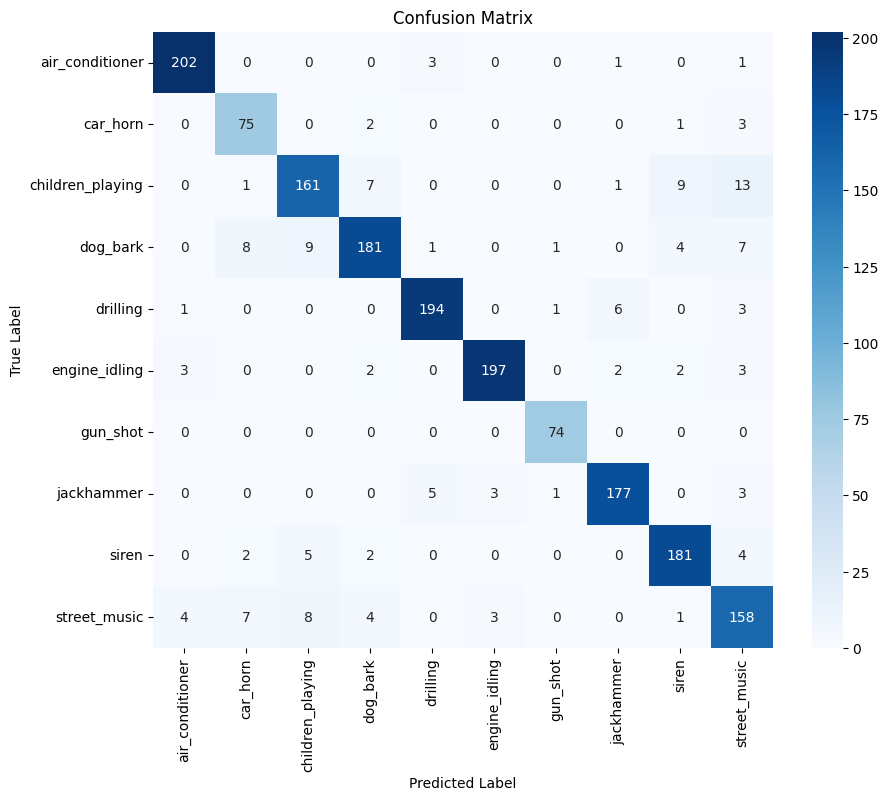

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report using text labels
report = classification_report(all_labels_text, all_predictions_text, target_names=list(label_map.values()))
print("Classification Report:\n", report)

# Compute confusion matrix using text labels
conf_matrix = confusion_matrix(all_labels_text, all_predictions_text, labels=list(label_map.values()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## 11. Make Predictions
Use the trained model to make predictions on new samples.

In [17]:
# Select a random sample from the validation set
sample_idx = 0
sample = valid_dataset[sample_idx]

# Make prediction
model.eval()
with torch.no_grad():
    sample['image'] = torch.tensor(np.array( [sample['image']]))
    sample['image'] = sample['image'].repeat(1, 3, 1, 1)  # since spectrogram has 1 channel
    print( sample['image'].shape )

    image = sample['image'].to(device)
    output = model(image).logits
    _, predicted_label = torch.max(output, 1)

actual_label_text = label_map[sample["label"]]
predicted_label_text = label_map[predicted_label.item()]

print(f'Actual Label: {actual_label_text}, Predicted Label: {predicted_label_text}')

torch.Size([1, 3, 224, 224])
Actual Label: children_playing, Predicted Label: children_playing


# Conclusion

In this notebook, we've successfully demonstrated how to apply a Vision Transformer (ViT) model for the task of sound classification. Here are the key takeaways:

1. **Spectrogram Conversion**: We converted audio data into Mel-spectrograms, which provide a visual representation of sound by capturing both time and frequency information.
2. **ViT Model Adaptation**: We adapted the Vision Transformer model, typically used for image classification, to work with these spectrograms. This involved converting single-channel spectrograms into three-channel images.
3. **Model Training and Evaluation**: We trained the ViT model on a subset of the UrbanSound8K dataset and evaluated its performance. The results showed that the model could effectively classify different sound categories.
4. **Visualization**: We visualized the model's performance using a confusion matrix, providing insights into which classes were classified correctly and where the model struggled.

This approach demonstrates the versatility of the ViT model in domains beyond traditional image classification, showcasing its potential in audio analysis tasks.